# Building an LSTM neural network

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import print_function

# import local library
import tools
import nnlstm

# import library to build the neural network
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam

In [3]:
#%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark
# for reproducibility
%watermark -a 'Paul Willot' -mvp numpy,scipy,keras

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Paul Willot 

CPython 2.7.10
IPython 4.0.0

numpy 1.8.0rc1
scipy 0.13.0b1
keras 0.1.3

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.39)
system     : Darwin
release    : 14.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


---
Let's gather the datas from the previous notebook

In [2]:
X_train, y_train, X_test, y_test, feature_names,max_features, classes_names, vectorizer = tools.load_pickle("data/unpadded_4_BacObjMetCon.pickle")

Loading 'data/unpadded_4_BacObjMetCon.pickle'...
Done. [0.20s]


and pad each vector to a regular size (necessary for the sequence processing)

In [3]:
X_train, X_test, y_train, y_test = nnlstm.pad_sequence(X_train, X_test, y_train, y_test, maxlen=100)

Pading sequences...
X_train shape: (1427, 100)
X_test shape: (357, 100)
Done. [0.01s]


Or directly get a **bigger training and testing set**:

In [18]:
X_train, y_train, X_test, y_test, feature_names, max_features, classes_names, vectorizer = tools.load_pickle("/Users/meat/Documents/NII/data/training_4_BacObjMetCon.pickle")

Loading '/Users/meat/Documents/NII/data/training_4_BacObjMetCon.pickle'...
Done. [3.73s]


Our data look like this:

In [8]:
X_train[0][:100]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   90,  112,    4, 2879,
       1570, 4267, 3476, 3052, 3962, 3495, 3052, 1193, 1664, 2741,  910,
       2297], dtype=int32)

In [9]:
# one-hot vector for the 4 different labels
y_train[0]

array([ 1.,  0.,  0.,  0.])

# Choosing the architecture

We use the [Keras](https://github.com/fchollet/keras) library, build on [Theano](https://github.com/Theano/Theano).

Here I choose a very simple architecture because of my low performance system (with no graphic card), but of course feel free to try any. Especially, stacking layers of LSTM could improve performance, according to [this paper](http://arxiv.org/abs/1506.02078) from Karpathy (which I used a lot as reference)

In [19]:
%%time
# take approximately 50s to build
dim_out = len(classes_names)

net = Sequential()
net.add(Embedding(max_features, 16))
net.add(LSTM(16, 16))
net.add(Dense(16, dim_out))
net.add(Dropout(0.5))
net.add(Activation('softmax'))
net.compile(loss='categorical_crossentropy', optimizer='adam', class_mode="categorical")

CPU times: user 44.3 s, sys: 433 ms, total: 44.8 s
Wall time: 44.8 s


Training on a small subset

In [20]:
batch_size   = 100
length_train = 15000  # length of the reduced training set (can put to -1 for all)
length_test  = 5000   # length of the reduced testing set  (can put to -1 for all)
nb_epoch     = 10
patience     = 2      # when to apply early stopping, if necessary
history = nnlstm.train_network(net,
                        X_train[:length_train],
                        y_train[:length_train],
                        X_test[:length_test],
                        y_test[:length_test],
                        nb_epoch,
                        batch_size=batch_size,
                        path_save="weights",
                        patience=patience) 

Training...
Train on 15000 samples, validate on 5000 samples
Epoch 0
15000/15000 [==============================] - 18s - loss: 1.2529 - acc: 0.3967 - val_loss: 1.0068 - val_acc: 0.6692
Saving at first epoch
Epoch 1
15000/15000 [==============================] - 19s - loss: 0.9894 - acc: 0.4896 - val_loss: 0.7673 - val_acc: 0.7256
Model improved, saving weight
Epoch 2
15000/15000 [==============================] - 19s - loss: 0.8732 - acc: 0.5356 - val_loss: 0.6531 - val_acc: 0.7342
Model improved, saving weight
Epoch 3
15000/15000 [==============================] - 17s - loss: 0.8567 - acc: 0.5409 - val_loss: 0.6549 - val_acc: 0.7284
Epoch 4
15000/15000 [==============================] - 18s - loss: 0.7902 - acc: 0.5599 - val_loss: 0.6103 - val_acc: 0.7364
Model improved, saving weight
Epoch 5
15000/15000 [==============================] - 17s - loss: 0.7517 - acc: 0.5753 - val_loss: 0.5976 - val_acc: 0.7414
Model improved, saving weight
Epoch 6
15000/15000 [==========================

The **weights are saved at each epoch**, and you can load '`best`' for the epoch with the higher (accuracy * (loss/10))

In [21]:
net.load_weights("weights/best.hdf5")

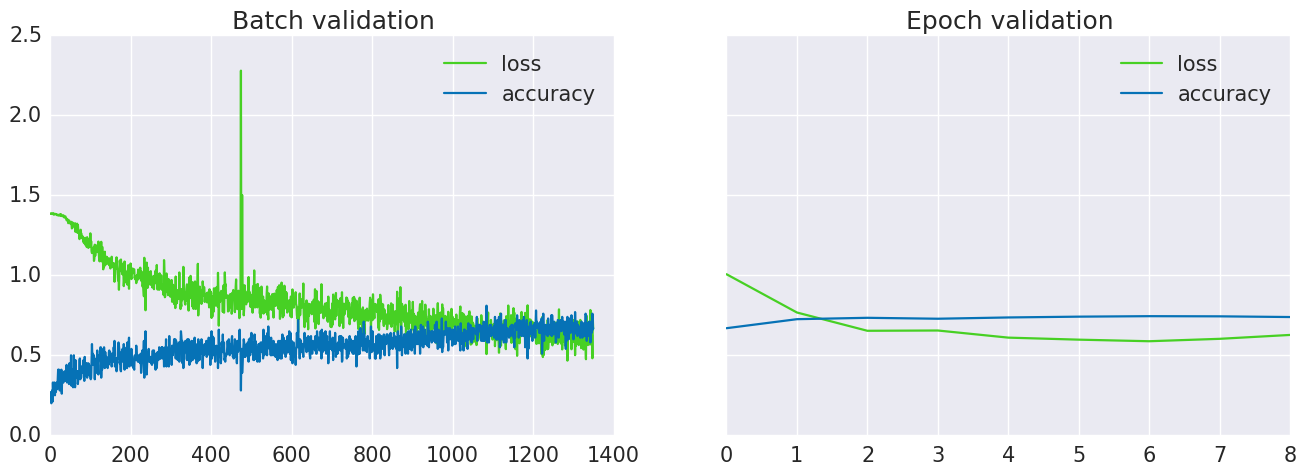

In [22]:
nnlstm.show_history(history)

# Evaluate the network

No decision: 0 / 4999  [0.00%]0 0
Accuracy: 0.864506
             precision    recall  f1-score   support

 BACKGROUND       0.56      0.51      0.54      1328
  OBJECTIVE       0.57      0.61      0.59      1196
     METHOD       0.87      0.88      0.87      1227
 CONCLUSION       0.99      0.99      0.99      1248

avg / total       0.74      0.74      0.74      4999

Confusion matrix:
[[ 682  504  139    3]
 [ 446  731   16    3]
 [  89   51 1078    9]
 [   2    4   12 1230]]


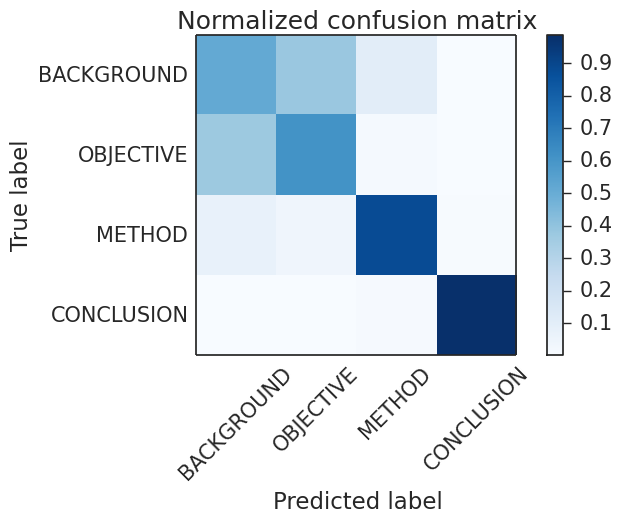

In [23]:
nnlstm.evaluate_network(net, X_test[:length_test], y_test[:length_test], classes_names, length=-1)

It is interesting to note the confusion of the network between `Background` and `Objective`, as the difference between these two labels is indeed usually quite thin.

---
## What's next?
There is a lot of possible improvments, from simply trying new features to implement transfer training...  

For an other nice and more complete example of LSTM neural network usage, you can look at [Karpathy's blogpost](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

Hopefully this notebook was helpful for you in some way. If there is some issues with this repo feel free to submit an issue or give me a comment, I'm always glad to have some feedback!  



Paul Willot
